# Clase 5: Interpolación Espacial. 


In [74]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import Voronoi, voronoi_plot_2d


## Interpolación por proximidad: Polígonos de Thiessen (Voronoi)

Para ejemplificar este tipo de interpolación espacial, primero usarmos un conjunto pequeño de datos simulados, y luego lo aplicaremos para un conjunto real de datos geoespaciales.

In [76]:
grid_x, grid_y = np.mgrid[0:1:0.01, 0:1:0.01]
print(grid_x.shape,grid_y.shape)

#Supondremos una función cualquiera para nuestros puntos de prueba, por ejemplo, una función trigonométrica con senos y cosenos.
def func(x, y):

    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2


#puntos aleatorios (observaciones, n=1000)
points=np.random.rand(100, 2)
values = func(points[:,0], points[:,1])
print(values.shape)

(100, 100) (100, 100)
(100,)


Grafiquemos los puntos generados, u "observaciones":

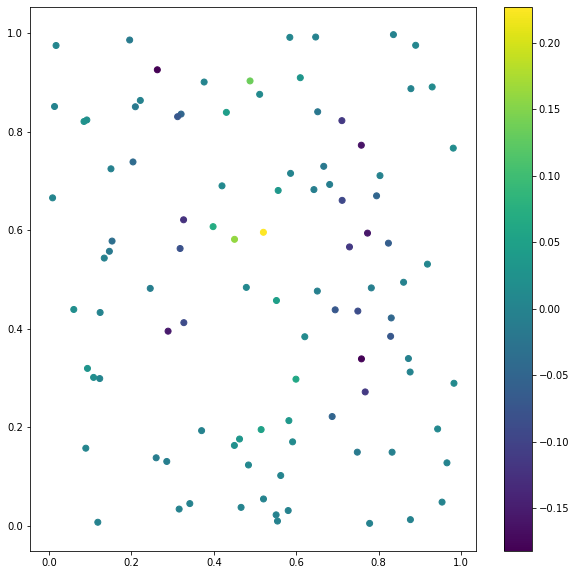

In [79]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.scatter(points[:,0], points[:,1],c=values)
plt.colorbar(im)
plt.show()

Para generar y visualizar los polígonos de Voronoi para nuestras observaciones, podemos utlizar las funciones implementeads en la librería scipy:

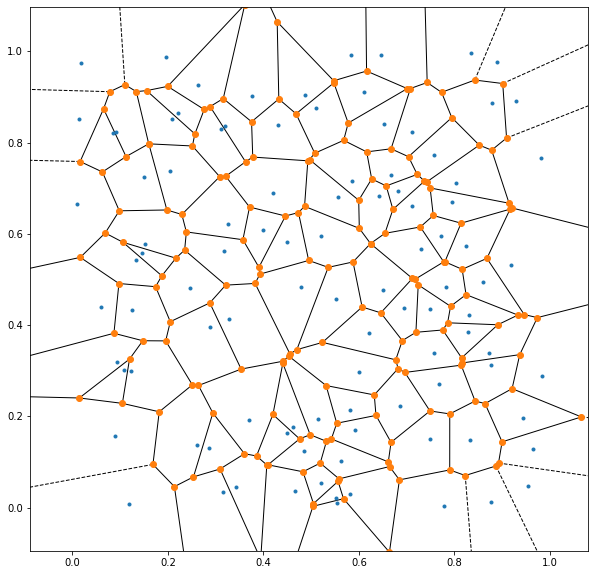

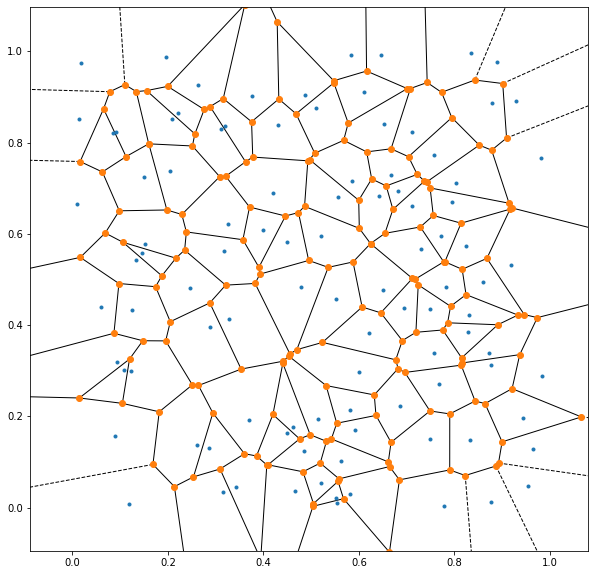

In [81]:
vor = Voronoi(points)

fig,ax=plt.subplots(1,1,figsize=(10,10))
voronoi_plot_2d(vor,ax=ax)


Con la función `griddata`, generamos una interpolación a partir del valor del atributo para el vecino más cercano:

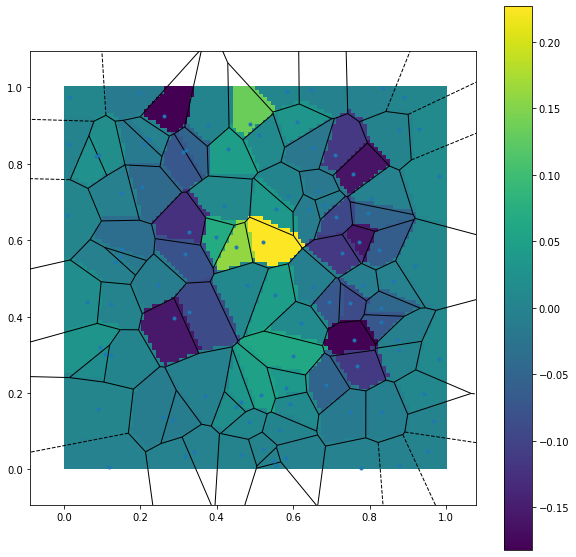

In [82]:
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

fig,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
voronoi_plot_2d(vor,ax=ax,show_vertices=False)
plt.colorbar(im)

Probemos ahora para un conjunto de datos reales, por ejemplo datos de elevación del suelo medidos para un conjunto de puntos en la ciudad de Valparaíso.

In [83]:
#elevaciones medidas para cada manzana de Valparaíso
dat=gpd.read_file('data/elevaciones_Valpo.gpkg')

#manzanas de Valparaíso

manz=gpd.read_file('data/manzanas_valpo.gpkg.shp')
manz=manz.to_crs('EPSG:32719')
dat=dat.to_crs('EPSG:32719')
dat.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2680 entries, 0 to 2679
Data columns (total 5 columns):
MANZENT_I     2680 non-null object
TOTAL_PERS    2680 non-null int64
TOTAL_VIVI    2680 non-null int64
Cortado (m    2680 non-null float64
geometry      2680 non-null geometry
dtypes: float64(1), geometry(1), int64(2), object(1)
memory usage: 104.8+ KB


,MANZENT_I,TOTAL_PERS,TOTAL_VIVI,Cortado (m,geometry
0,5101021001002,164,24,51.0,POINT (253628.649 6343319.337)
1,5101021001003,109,14,29.0,POINT (253197.732 6343212.118)
2,5101011002001,10,4,47.0,POINT (252739.180 6343029.963)
3,5101021002004,86,44,39.0,POINT (253962.511 6343116.936)
4,5101011002002,137,41,68.0,POINT (252868.545 6342762.326)


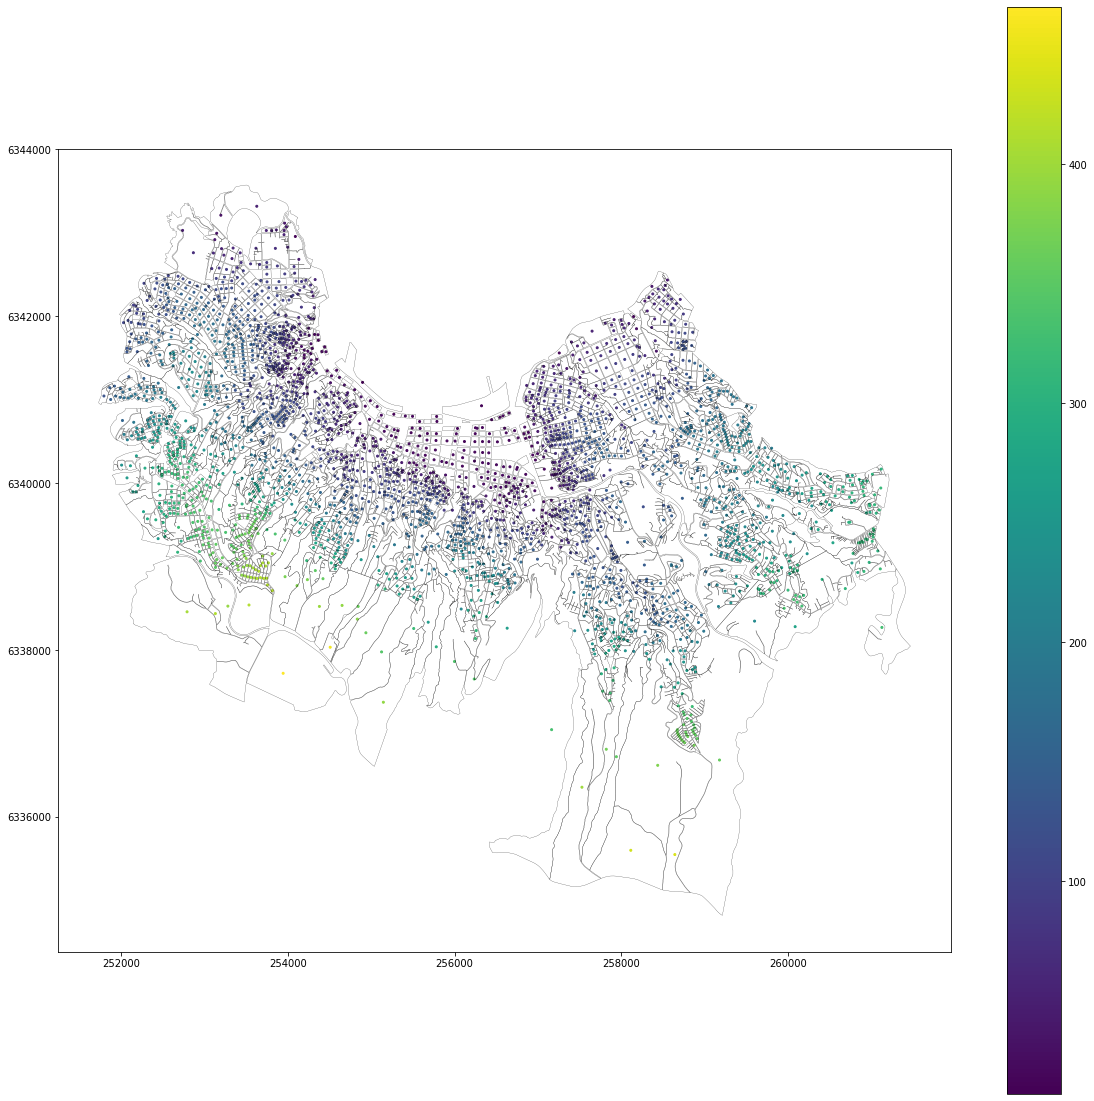

In [84]:

fig,ax=plt.subplots(1,1,figsize=(20,20))
dat.plot(ax=ax,column='Cortado (m',markersize=4,legend=True)
manz.boundary.plot(ax=ax,color='k',lw=0.2)

dat.head()

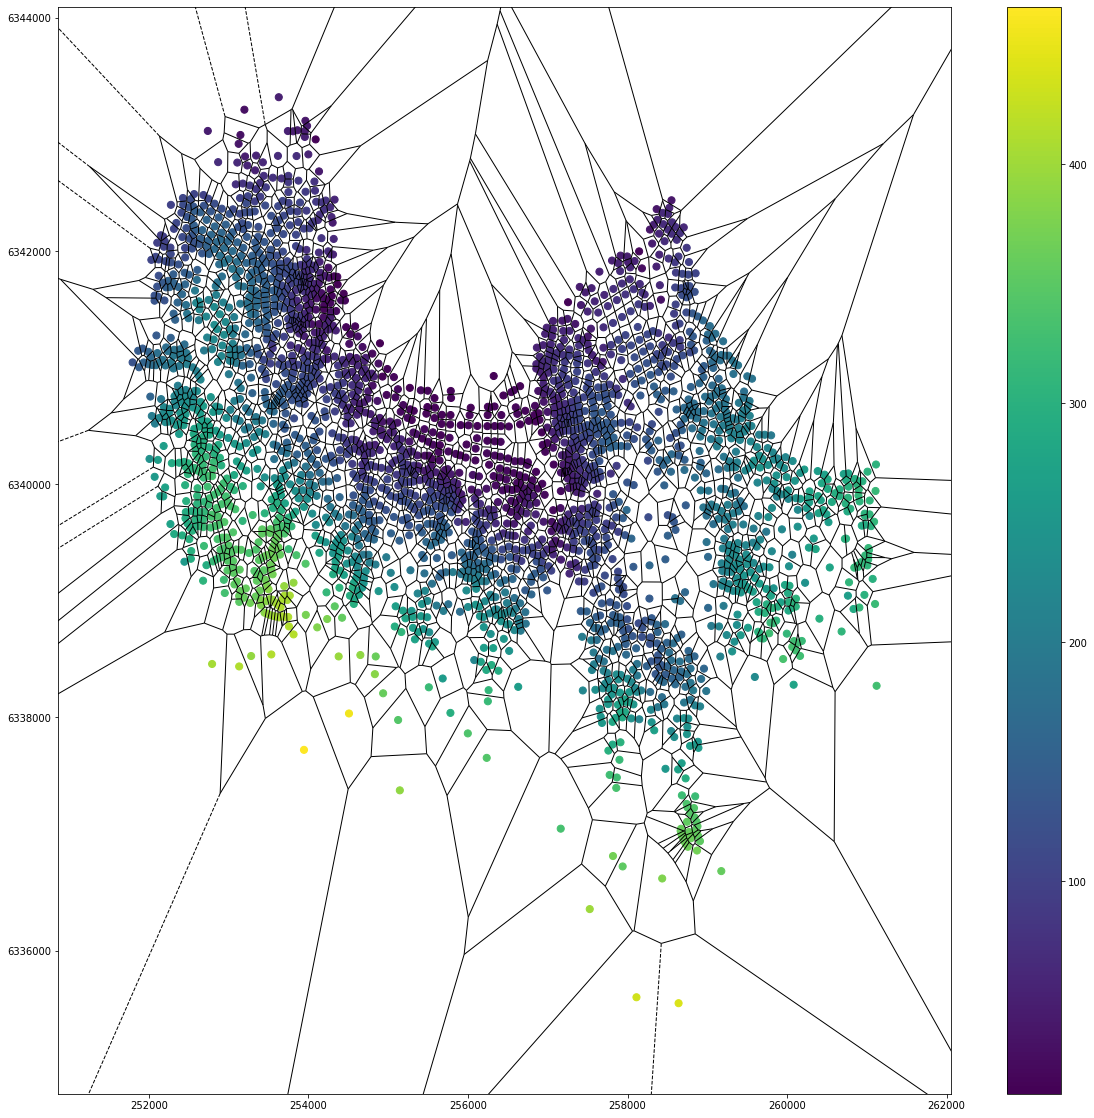

In [103]:
dat['x']=dat.centroid.x
dat['y']=dat.centroid.y
dat['z']=dat['Cortado (m']

points=np.array([[x,y] for x,y, in zip(dat.x,dat.y)])
values =np.array([z for z in dat.z])
vor = Voronoi(points)

voronoi_plot_2d(vor,ax=ax)


fig, ax = plt.subplots(1, 1, figsize=(20,20))
art = ax.scatter(dat.x,dat.y, s=50, c=dat.z, cmap='viridis')
voronoi_plot_2d(vor,ax=ax,show_vertices=False,show_points=False)

plt.colorbar(art)




(94, 78) (94, 78)


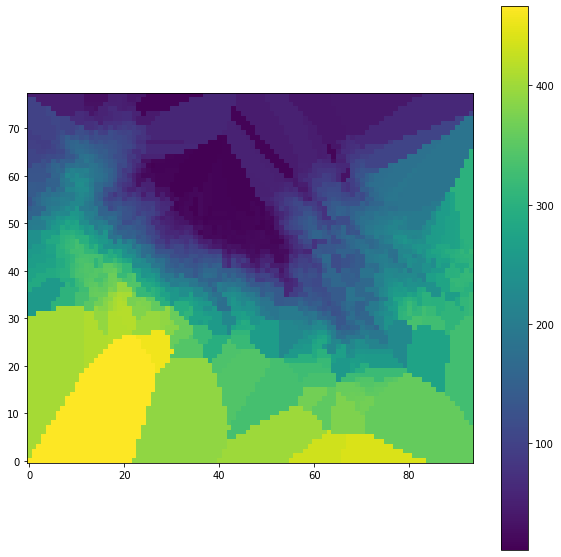

In [105]:
grid_x, grid_y = np.mgrid[dat.x.min():dat.x.max():100, dat.y.min():dat.y.max():100]
print(grid_x.shape,grid_y.shape)

grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

fig,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.imshow(grid_z0.T, origin='lower')
plt.colorbar(im)


## Interpolación ponderada inversamente por distancia (IDW):

Para este caso, definiremos nuestra propia función para calcular interpoaciones IDW.

In [154]:
import math

def dist(x1,x2,y1,y2):
    d=math.sqrt((x1-x2)**2+(y1-y2)**2)
    return(d)

def idwr(x, y, z, xi, yi,n):
    #xi,yi: puntos donde queremos estimar z
    #x,y,z: observaciones
    
    lstxyzi = []
    for p in range(len(xi)):
        lstdist = []
        for s in range(len(x)):
            d = (dist(x[s], y[s], xi[p], yi[p]))
            lstdist.append(d)
        sumsup = list((1 / np.power(lstdist, n)))
        suminf = np.sum(sumsup)
        sumsup = np.sum(np.array(sumsup) * np.array(z))
        u = sumsup / suminf
        xyzi = [xi[p], yi[p], u]
        lstxyzi.append(u)
    return(np.array(lstxyzi))



2680 2680
78 78
(78,) (78, 78)


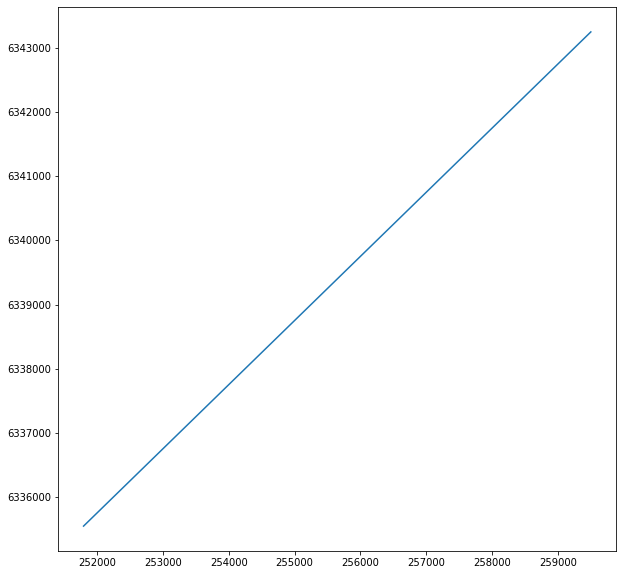

In [159]:
x=dat.x
y=dat.y
z=values

points=np.array([[x,y] for x,y, in zip(dat.x,dat.y)])
values =np.array([z for z in dat.z])


print(len(points[:,0]),len(values),)
xi=np.arange(dat.x.min(),dat.x.max(),100)
yi=np.arange(dat.y.min(),dat.y.max(),100)

points_grid=np.array([[x,y] for x,y, in zip(xi,yi)])
xi=points_grid[:,0]
yi=points_grid[:,1]

print(len(xi),len(yi))
X,Y = np.meshgrid(xi,yi)


values = idwr(points[:,0],points[:,1],values,xi,yi,n=2)
print(values.shape,X.shape)

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.plot(xi,yi)

